In [14]:
###  采用Min-Max标准化进行特征归一化，将特征数据放大到[0,1]区间


import pandas as pd
from sklearn.preprocessing import MinMaxScaler

# 载入数据
df = pd.read_csv('old_data-869_Y_ave.csv')


scaler = MinMaxScaler()  # 创建MinMaxScaler对象

# 对DataFrame的特征数据进行归一化
df_normalized = pd.DataFrame(scaler.fit_transform(df), columns=df.columns)

# 保存归一化后的数据为新的CSV文件
df_normalized.to_csv('df_normalized_869.csv', index=False)

In [13]:
"""综合 XGBoost 的三个重要性指标（weight, gain, cover）来推导出排名前 10 的“综合重要性变量”，
即在这三个指标中都表现突出的变量。"""


import pandas as pd
import xgboost as xgb
import shap
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split

# === 1. 读取数据 ===

df = pd.read_csv("old_data-869_Y_ave.csv")
X = df.iloc[:, :-2]
y = df.iloc[:, -1]

# === 2. 拆分数据集 ===
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# === 3. 初步训练 XGBoost 模型 ===
model = xgb.XGBRegressor(n_estimators=200, max_depth=4, learning_rate=0.05, random_state=42)
model.fit(X_train, y_train)


types = ['weight', 'gain', 'cover']
importance_data = {}

for imp_type in types:
    score = model.get_booster().get_score(importance_type=imp_type)
    df = pd.DataFrame(score.items(), columns=['Feature', imp_type])
    importance_data[imp_type] = df

# === Step 2: 合并成一个 DataFrame ===
df_merged = importance_data['weight']
df_merged = df_merged.merge(importance_data['gain'], on='Feature', how='outer')
df_merged = df_merged.merge(importance_data['cover'], on='Feature', how='outer')

# 缺失值填 0（部分特征可能未在所有指标中出现）
df_merged = df_merged.fillna(0)

# === Step 3: 各指标归一化（0-1） ===
for col in ['weight', 'gain', 'cover']:
    max_val = df_merged[col].max()
    df_merged[col + '_norm'] = df_merged[col] / max_val if max_val > 0 else 0

# === Step 4: 计算综合得分（平均法 or 加权法）===
df_merged['importance_score'] = df_merged[['weight_norm', 'gain_norm', 'cover_norm']].mean(axis=1)

# === Step 5: 按综合得分排序，提取前10 ===
top10_combined = df_merged.sort_values(by='importance_score', ascending=False).head(15)

print("综合重要性 Top 15 变量：")
print(top10_combined[['Feature', 'weight', 'gain', 'cover', 'importance_score']])

# === 可选: 保存结果为 Excel ===
# top10_combined.to_excel("xgb_top10_combined_importance.xlsx", index=False)

✅ 综合重要性 Top 15 变量：
    Feature  weight      gain       cover  importance_score
58    Q18A4    44.0  2.670138  356.363647          0.822858
13    Q10B3    47.0  0.374854  512.170227          0.646261
107   Q30A7    12.0  2.528583  368.416656          0.607075
99   Q29A11    45.0  0.491114  425.488892          0.597489
71   Q22C03    51.0  0.644187  313.313721          0.589752
56    Q18A2    22.0  2.070396  322.363647          0.587167
128    Q8B1    41.0  0.424642  433.414642          0.568164
76   Q22C08    50.0  0.457742  297.140015          0.550650
50   Q16A10    40.0  0.699589  340.250000          0.541837
6      ADQ9    32.0  0.895498  376.375000          0.536044
89   Q29A01    52.0  0.496584  234.942307          0.532108
88    Q27A8    42.0  0.886716  239.142853          0.519154
33    Q14B3    22.0  0.756192  457.000000          0.501490
34    Q14B4    24.0  0.282528  533.416687          0.499669
51    Q17A1    34.0  0.484888  361.617645          0.489013


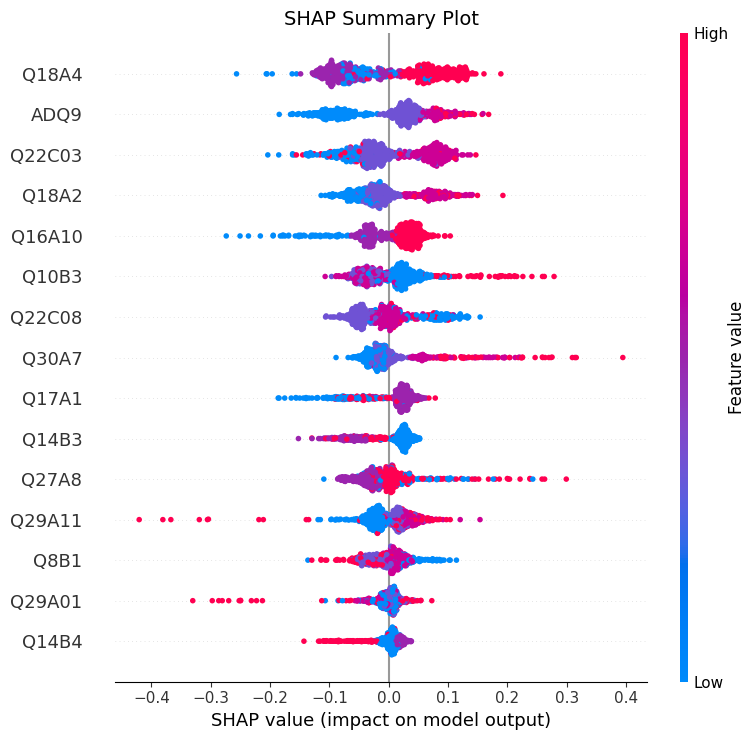

In [7]:
import pandas as pd
import xgboost as xgb
import shap
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# === 1. 数据准备 ===
df = pd.read_csv("df_normalized_869.csv")
X = df.iloc[:, :-2]
y = df.iloc[:, -1]

# === 2. 前15个重要特征（按 importance_score 排好顺序）===
top15_features = [
    "Q18A4", "Q10B3", "Q30A7", "Q29A11", "Q22C03",
    "Q18A2", "Q8B1", "Q22C08", "Q16A10", "ADQ9",
    "Q29A01", "Q27A8", "Q14B3", "Q14B4", "Q17A1"
]

# === 3. 数据子集 + 划分 ===
X_top15 = X[top15_features]
X_train_15, X_test_15, y_train_15, y_test_15 = train_test_split(X_top15, y, test_size=0.2, random_state=42)

# === 4. 训练模型（仅用 top15 特征）===
model_top15 = xgb.XGBRegressor(n_estimators=200, learning_rate=0.05, max_depth=4, random_state=42)
model_top15.fit(X_train_15, y_train_15)

# === 5. SHAP 分析（CPU兼容）===
explainer = shap.TreeExplainer(model_top15)
shap_values = explainer.shap_values(X_train_15)

# === 6. 生成 SHAP Summary Plot
shap.summary_plot(
    shap_values,
    X_train_15[top15_features],
    plot_type="dot",
    show=False
)


plt.title("SHAP Summary Plot", fontsize=14)
plt.tight_layout()
plt.show()

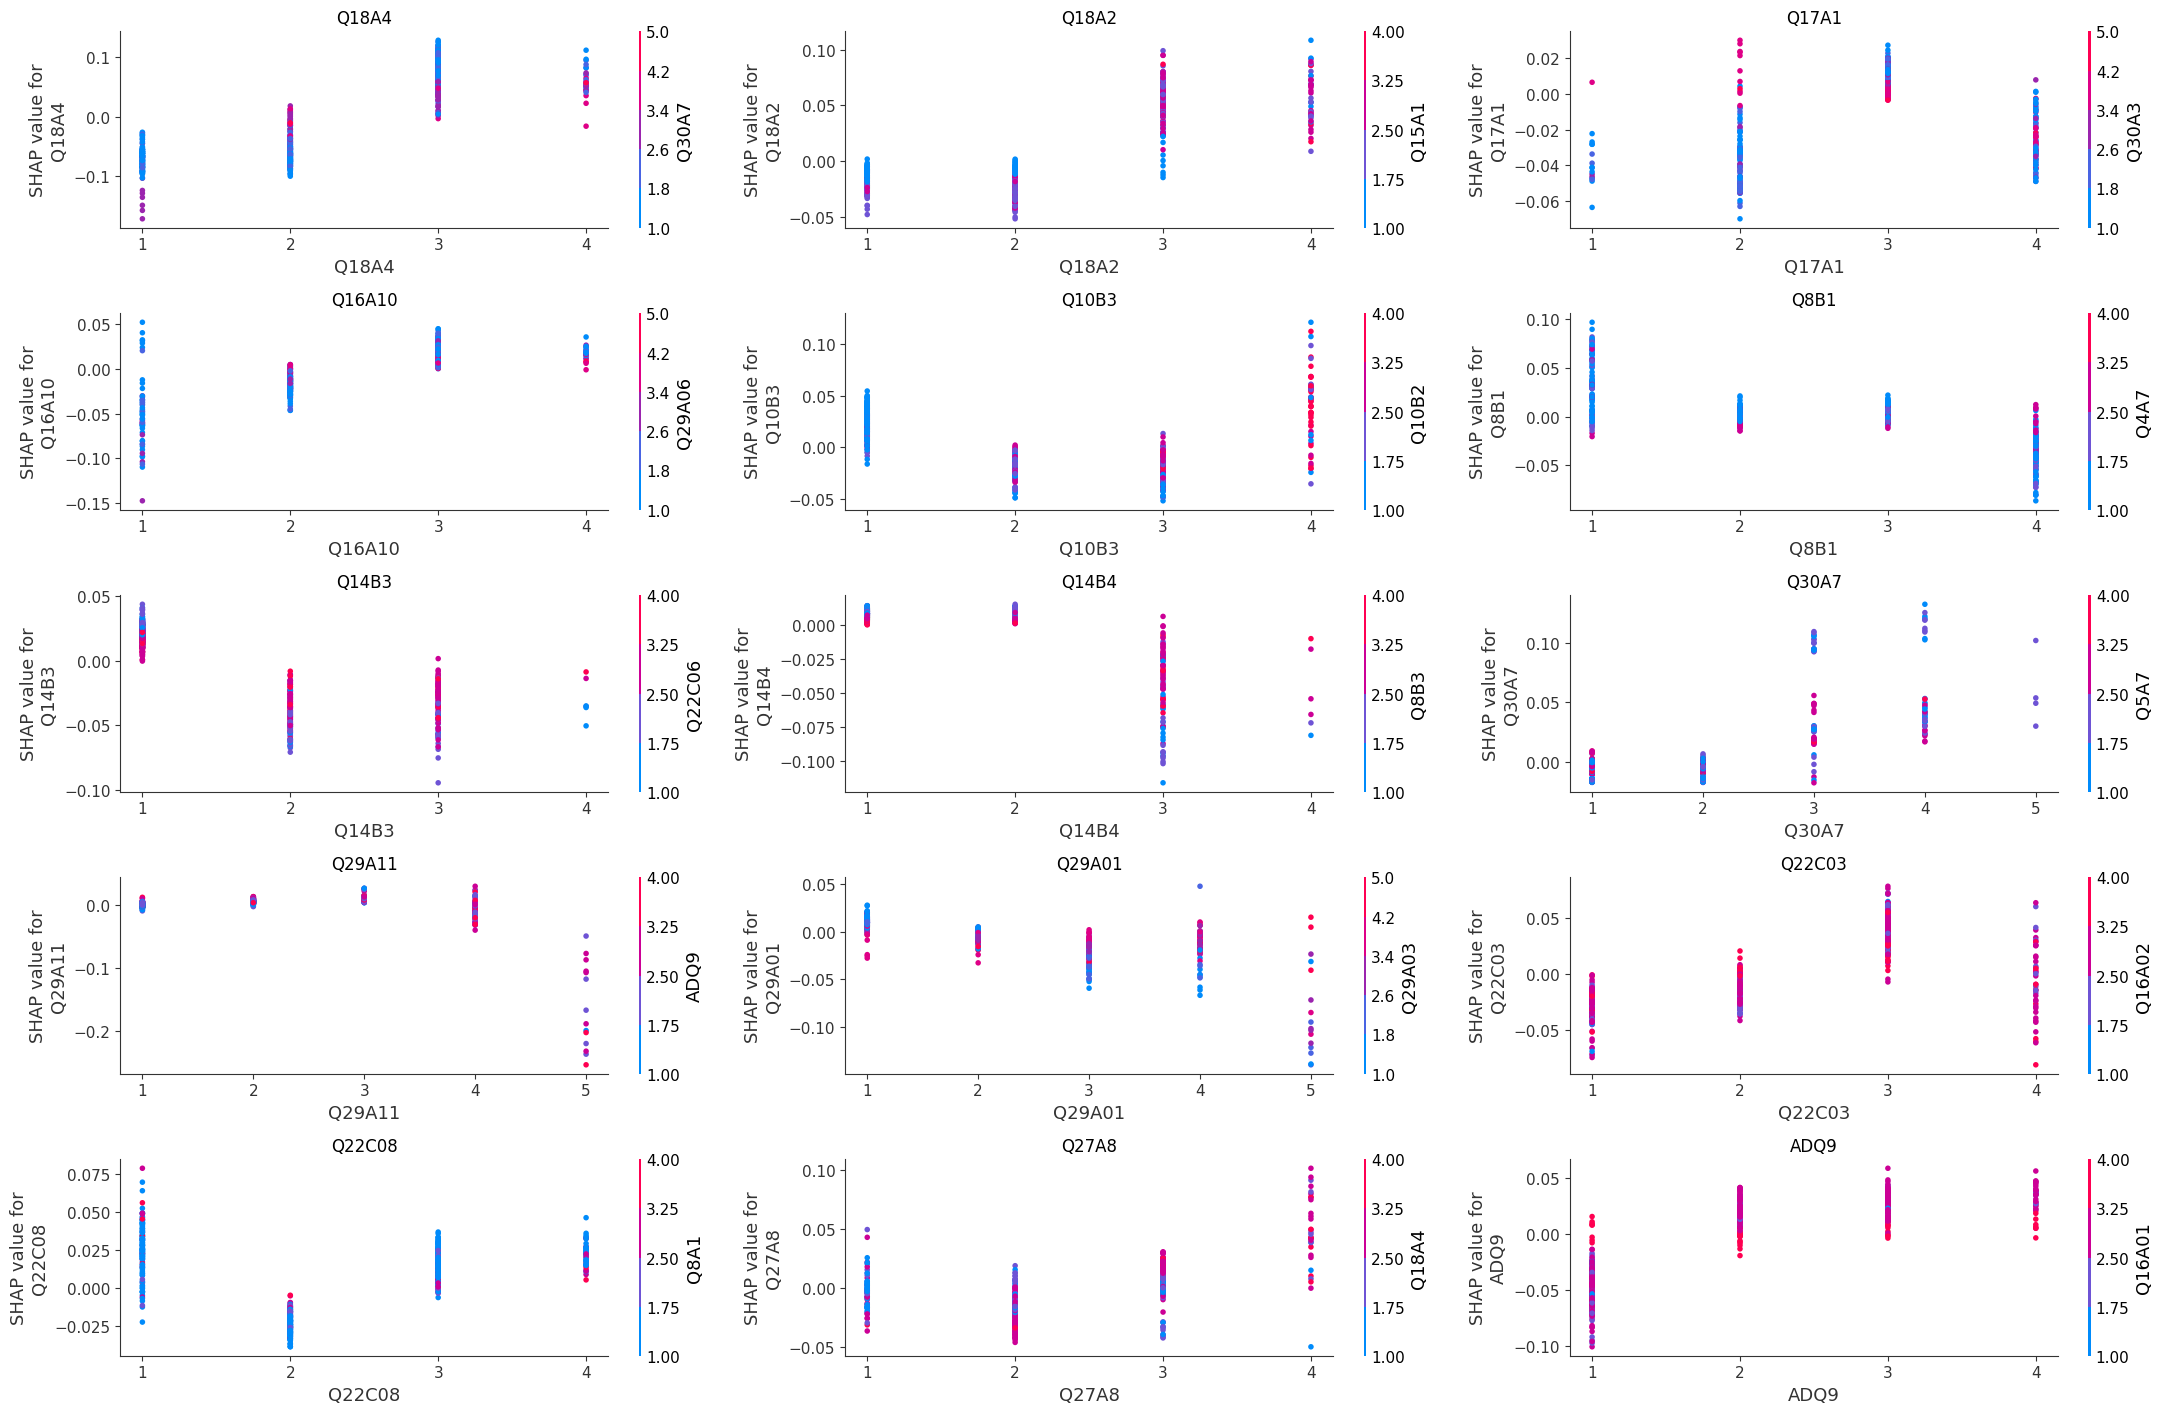

In [8]:
"""将基于 XGBoost 三类指标（weight、gain、cover）加权选出的前15个变量的 SHAP dependence plots，
全都绘制在一张 3×5 网格图中，便于统一展示与论文使用。"""

import pandas as pd
import xgboost as xgb
import shap
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split

# === 1. 加载数据 ===
df = pd.read_csv("old_data-869_Y_ave.csv")
X = df.iloc[:, :-2]
y = df.iloc[:, -1]

# === 2. 拆分数据 ===
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# === 3. 训练 XGBoost 模型 ===
model = xgb.XGBRegressor(n_estimators=200, learning_rate=0.05, max_depth=4, random_state=42)
model.fit(X_train, y_train)


explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_train)

# === 4. 要绘制的特征 ===
selected_features = ["Q18A4", "Q18A2", "Q17A1", "Q16A10", "Q10B3",
                     "Q8B1", "Q14B3", "Q14B4", "Q30A7", "Q29A11",
                     "Q29A01", "Q22C03", "Q22C08", "Q27A8", "ADQ9"]

# === 5. 创建 5x3 网格图 ===
n_rows, n_cols = 5, 3
fig, axes = plt.subplots(n_rows, n_cols, figsize=(22, 15))
axes = axes.flatten()

# === 6. 绘制 SHAP dependence plot 并设置 X 轴为单位间隔 ===
for i, feature in enumerate(selected_features):
    shap.dependence_plot(
        feature,
        shap_values,
        X_train,
        ax=axes[i],
        show=False
    )
    axes[i].set_title(feature, fontsize=12)

    # 设置 X 轴为单位间隔
    try:
        min_val = int(np.floor(X_train[feature].min()))
        max_val = int(np.ceil(X_train[feature].max()))
        axes[i].set_xticks(np.arange(min_val, max_val + 1, 1))
    except:
        pass

# === 7. 格式并保存图像 ===
plt.tight_layout(rect=[0, 0, 1, 0.95])
# plt.savefig("shap_dependence_combined_ticks1_cpu.png", dpi=300)
plt.show()


In [9]:
pip install catboost shap

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 8.7 MB/s eta 0:00:00


In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, learning_curve, KFold
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor

# === 1. 数据加载 ===
df = pd.read_csv("df_normalized_869.csv")
X = df.iloc[:, :-2]
y = df.iloc[:, -1]

# === 2. 数据集划分 ===
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# === 3. 模型配置 ===
models = {
    "RandomForest": RandomForestRegressor(max_depth=10, min_samples_split=5, n_estimators=100, random_state=42),
    "XGBoost": XGBRegressor(learning_rate=0.01, max_depth=3, n_estimators=200, objective="reg:squarederror", random_state=42),
    "LightGBM": LGBMRegressor(learning_rate=0.01, max_depth=-1, n_estimators=200, random_state=42),
    "CatBoost": CatBoostRegressor(depth=4, iterations=100, learning_rate=0.1, verbose=0, random_state=42)
}

results = []
residuals = {}

# === 4. 评估并保存每个模型结果 ===
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    # === Bootstrap RMSE 置信区间 ===
    boot_rmse = []
    for _ in range(1000):
        idx = np.random.choice(len(y_test), len(y_test), replace=True)
        boot_rmse.append(np.sqrt(mean_squared_error(y_test.iloc[idx], y_pred[idx])))
    ci_lower = np.percentile(boot_rmse, 2.5)
    ci_upper = np.percentile(boot_rmse, 97.5)

    results.append({
        "Model": name,
        "MSE": round(mse, 4),
        "RMSE": round(rmse, 4),
        "RMSE 95% CI": f"{ci_lower:.4f}–{ci_upper:.4f}",
        "MAE": round(mae, 4),
        "R2": round(r2, 4)
    })

    residuals[name] = y_test - y_pred

# === 5. 输出性能评估表格 ===
results_df = pd.DataFrame(results)
print(results_df)



[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001800 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 571
[LightGBM] [Info] Number of data points in the train set: 695, number of used features: 146
[LightGBM] [Info] Start training from score 0.507914
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -

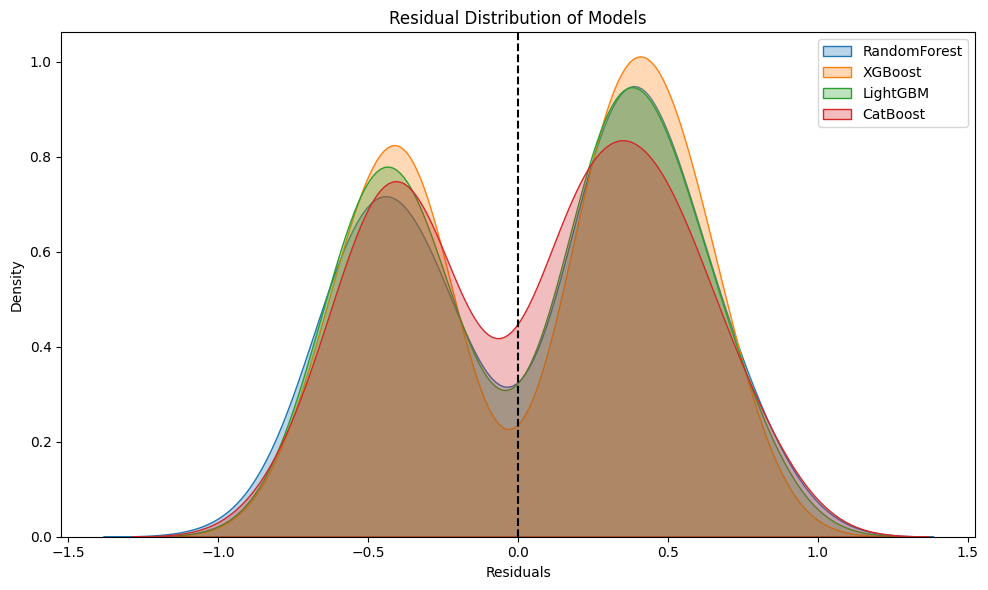

In [11]:
# === 6. 可视化：残差分布图 ===
plt.figure(figsize=(10, 6))
for name in residuals:
    sns.kdeplot(residuals[name], label=f"{name}", fill=True, alpha=0.3)
plt.axvline(0, color='black', linestyle='--')
plt.title("Residual Distribution of Models")
plt.xlabel("Residuals")
plt.ylabel("Density")
plt.legend()
plt.tight_layout()
plt.show()

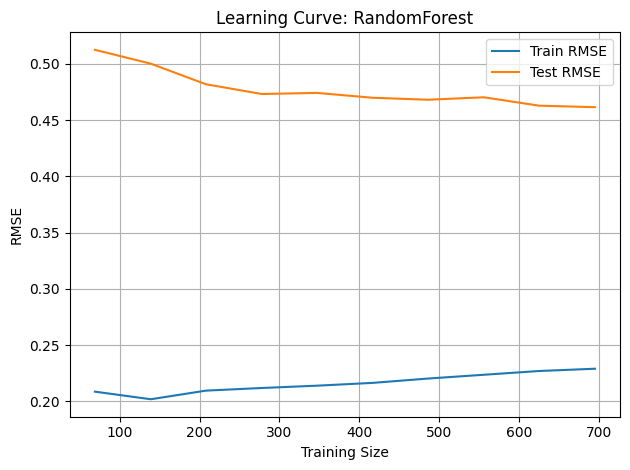

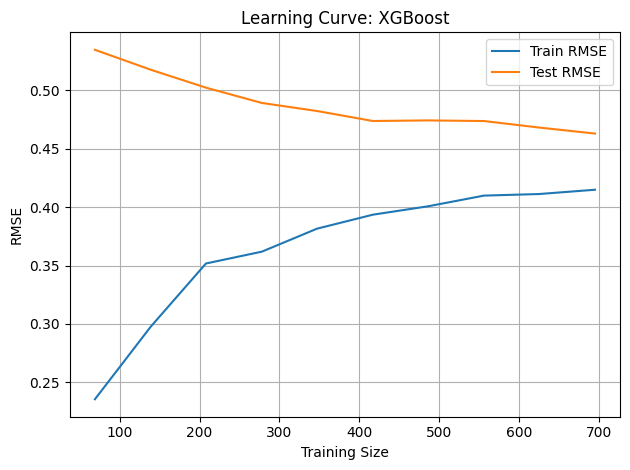

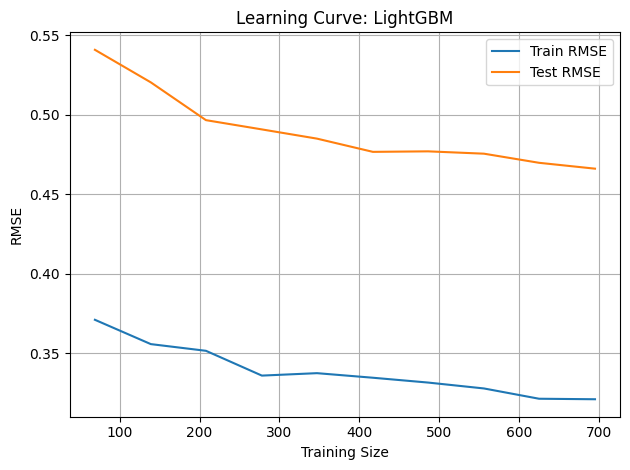

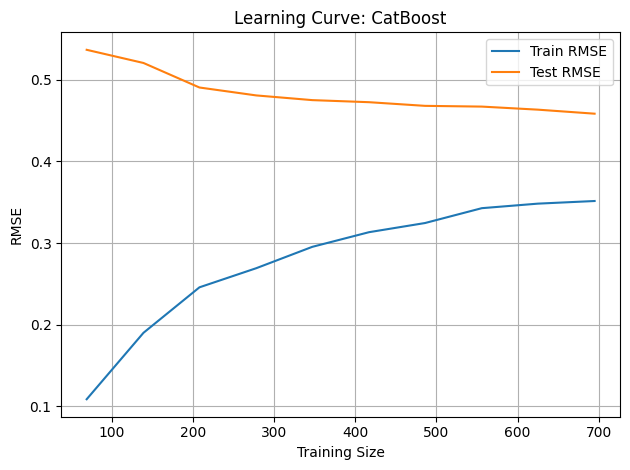

In [12]:
# === 7. 可视化：学习曲线 ===
cv = KFold(n_splits=5, shuffle=True, random_state=42)
for name, model in models.items():
    train_sizes, train_scores, test_scores = learning_curve(
        model, X, y, cv=cv, scoring='neg_mean_squared_error',
        train_sizes=np.linspace(0.1, 1.0, 10), n_jobs=-1
    )
    train_rmse = np.sqrt(-train_scores.mean(axis=1))
    test_rmse = np.sqrt(-test_scores.mean(axis=1))

    plt.figure()
    plt.plot(train_sizes, train_rmse, label='Train RMSE')
    plt.plot(train_sizes, test_rmse, label='Test RMSE')
    plt.xlabel("Training Size")
    plt.ylabel("RMSE")
    plt.title(f"Learning Curve: {name}")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()